In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score 

####  Piecewise function：
$$y=\begin{cases}
2 + 3x_1 + 4x_2 + 20x_1x_2 & 0 \leq x_1 < 0.5, 0 \leq x_2 < 0.5 \\
2 + 3x_1 + 4x_2 - 10x_1x_2 & 0 \leq x_1 < 0.5, 0.5 \leq x_2 < 1 \\
2 + 3x_1 + 4x_2 + 10x_1x_2 & 0.5 \leq x_1 < 1, 0 \leq x_2 < 0.5 \\
2 + 3x_1 + 4x_2 - 5x_1x_2 & 0.5 \leq x_1 < 1, 0.5 \leq x_2 < 1
\end{cases}$$

In [2]:
# Create dataset
np.random.seed(42)
X = np.random.rand(50000, 2)

def myfun(x):
    
    if 0 <= x[0] and x[0] < 0.5 and 0 <= x[1] and x[1] < 0.5:
        y = 2 + 3 * x[0] + 4 * x[1] + 20 * x[0] * x[1]  
        
    elif 0 <= x[0] and x[0] < 0.5 and 0.5 <= x[1] and x[1] < 1:
        y = 2 + 3 * x[0] + 4 * x[1] - 10 * x[0] * x[1] 
    
    elif 0.5 <= x[0] and x[0] < 1 and 0 <= x[1] and x[1] < 0.5:
        y = 2 + 3 * x[0] + 4 * x[1] + 10 * x[0] * x[1]  
    
    else:
        y = 2 + 3 * x[0] + 4 * x[1] - 5 * x[0] * x[1]  
        
    return y

y = np.apply_along_axis(myfun, 1, X) + np.random.randn(50000)

In [3]:
# Get the interaction term of x_1 times x_2
X_inter = X[:,0] * X[:,1]
X = np.concatenate((X, X_inter.reshape(-1,1)), axis=1)

X_train, X_eval, X_test = X[:35000], X[35000:45000], X[45000:]
y_train, y_eval, y_test = y[:35000], y[35000:45000], y[45000:]

In [4]:
X[:5]

array([[0.37454012, 0.95071431, 0.35608065],
       [0.73199394, 0.59865848, 0.43821438],
       [0.15601864, 0.15599452, 0.02433805],
       [0.05808361, 0.86617615, 0.05031064],
       [0.60111501, 0.70807258, 0.42563306]])

In [5]:
y[:5]

array([4.20838218, 6.92343086, 3.47866357, 2.93824463, 5.93281742])

# $M_{Linear}$: 
### Linear regression model with three input variables, $x_1$, $x_2$ and $x_1x_2$

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.intercept_, lin_reg.coef_

(2.992162141243706, array([ 5.64233603,  1.72220449, -6.28848671]))

In [7]:
pred = lin_reg.predict(X_test)
print("Linear regression model result:")
print("R2 = {:.4f}".format(r2_score(y_test, pred)), "MSE = {:.4f}".format(mean_squared_error(y_test, pred)))

Linear regression model result:
R2 = 0.2286 MSE = 3.2427


# $M_{Neural2}$:
### Three-layer neural network with two input variables, $x_1$ and $x_2$ 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim


class NN3(nn.Module):
    
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        
        super(NN3, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(in_dim, n_hidden_1),
            nn.Tanh(),
            nn.Linear(n_hidden_1, n_hidden_2), 
            nn.Tanh(),
            nn.Linear(n_hidden_2, out_dim)
        )

    def forward(self, x):

        x = self.net(x)

        return x

In [9]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# input : x_1, x_2
model = NN3(2, 8, 4, 1)
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_fun = nn.MSELoss()

In [10]:
def compute_val(X, y):
    inputs, labels = torch.tensor(X[:,:2], dtype=torch.float), torch.tensor(y, dtype=torch.float).reshape(-1,1)
    model.eval()
    outputs = model(inputs)
    pred = outputs.detach().numpy()
    mse = mean_squared_error(y, pred)
    r2 = r2_score(y, pred)
    return mse, r2

inputs, labels = torch.tensor(X_train[:,:2], dtype=torch.float), torch.tensor(y_train, dtype=torch.float).reshape(-1,1)

model.train()
best_eval = np.inf
bad_counter = 0
for epoch in range(40000):
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fun(outputs, labels)
    loss.backward()
    optimizer.step()
    
    eval_mse, eval_r2 = compute_val(X_eval, y_eval)
    test_mse, test_r2 = compute_val(X_test, y_test)
    
    if eval_mse < best_eval:
        best_eval = eval_mse
        best_test_mse = test_mse
        best_test_r2 = test_r2
        bad_counter = 0
        
    else:
        bad_counter += 1
        
    if bad_counter == 50:
        break
    
    if epoch % 200 == 0:
        print("epoch = {}".format(epoch), "loss = {:.4f}".format(loss.item()),
             "eval_mse = {:.4f}".format(eval_mse), "test_mse = {:.4f}".format(test_mse))

epoch = 0 loss = 29.8230 eval_mse = 29.5404 test_mse = 29.2464
epoch = 200 loss = 4.5891 eval_mse = 4.6098 test_mse = 4.4831
epoch = 400 loss = 4.2559 eval_mse = 4.2923 test_mse = 4.1850
epoch = 600 loss = 4.0825 eval_mse = 4.1064 test_mse = 4.0078
epoch = 800 loss = 3.1726 eval_mse = 3.1705 test_mse = 3.0916
epoch = 1000 loss = 2.0709 eval_mse = 2.0817 test_mse = 2.0381
epoch = 1200 loss = 1.6846 eval_mse = 1.7009 test_mse = 1.6528
epoch = 1400 loss = 1.5484 eval_mse = 1.5649 test_mse = 1.5126
epoch = 1600 loss = 1.4756 eval_mse = 1.4907 test_mse = 1.4369
epoch = 1800 loss = 1.4300 eval_mse = 1.4439 test_mse = 1.3913
epoch = 2000 loss = 1.3983 eval_mse = 1.4119 test_mse = 1.3609
epoch = 2200 loss = 1.3758 eval_mse = 1.3894 test_mse = 1.3400
epoch = 2400 loss = 1.3597 eval_mse = 1.3729 test_mse = 1.3257
epoch = 2600 loss = 1.3470 eval_mse = 1.3597 test_mse = 1.3151
epoch = 2800 loss = 1.3359 eval_mse = 1.3480 test_mse = 1.3061
epoch = 3000 loss = 1.3246 eval_mse = 1.3364 test_mse = 1.2

In [11]:
print("Three-layer neural network with two input variables:")
print("R2 = {:.4f}".format(best_test_r2), "MSE = {:.4f}".format(best_test_mse))

Three-layer neural network with two input variables:
R2 = 0.7491 MSE = 1.0547


# $M_{Neural3}$:
### Three-layer neural network with three input variables, $x_1$ , $x_2$ and $x_1x_2$ 

In [12]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# input : x_1, x_2, x_1*x_2
model = NN3(3, 8, 4, 1)
optimizer = optim.Adam(model.parameters(),lr=0.005)
loss_fun = nn.MSELoss()

In [13]:
inputs, labels = torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.float).reshape(-1,1)

def compute_val(X, y):
    inputs, labels = torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float).reshape(-1,1)
    model.eval()
    outputs = model(inputs)
    pred = outputs.detach().numpy()
    mse = mean_squared_error(y, pred)
    r2 = r2_score(y, pred)
    return mse, r2
    
model.train()
best_eval = np.inf
bad_counter = 0
for epoch in range(40000):
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fun(outputs, labels)
    loss.backward()
    optimizer.step()
    
    eval_mse, eval_r2 = compute_val(X_eval, y_eval)
    test_mse, test_r2 = compute_val(X_test, y_test)
    
    if eval_mse < best_eval:
        best_eval = eval_mse
        best_test_mse = test_mse
        best_test_r2 = test_r2
        bad_counter = 0
        
    else:
        bad_counter += 1
        
    if bad_counter == 50:
        break
    
    if epoch % 200 == 0:
        print("epoch = {}".format(epoch), "loss = {:.4f}".format(loss.item()),
             "eval_mse = {:.4f}".format(eval_mse), "test_mse = {:.4f}".format(test_mse))

epoch = 0 loss = 25.2653 eval_mse = 24.9644 test_mse = 24.6902
epoch = 200 loss = 4.2708 eval_mse = 4.3049 test_mse = 4.1926
epoch = 400 loss = 4.2195 eval_mse = 4.2550 test_mse = 4.1471
epoch = 600 loss = 3.7991 eval_mse = 3.8336 test_mse = 3.7187
epoch = 800 loss = 3.2889 eval_mse = 3.2869 test_mse = 3.2077
epoch = 1000 loss = 2.9468 eval_mse = 2.9235 test_mse = 2.8789
epoch = 1200 loss = 1.9227 eval_mse = 1.9357 test_mse = 1.9010
epoch = 1400 loss = 1.6103 eval_mse = 1.6220 test_mse = 1.5895
epoch = 1600 loss = 1.4961 eval_mse = 1.5069 test_mse = 1.4668
epoch = 1800 loss = 1.4366 eval_mse = 1.4460 test_mse = 1.4011
epoch = 2000 loss = 1.3982 eval_mse = 1.4064 test_mse = 1.3599
epoch = 2200 loss = 1.3669 eval_mse = 1.3750 test_mse = 1.3271
epoch = 2400 loss = 1.3390 eval_mse = 1.3476 test_mse = 1.2993
epoch = 2600 loss = 1.3097 eval_mse = 1.3189 test_mse = 1.2730
epoch = 2800 loss = 1.2834 eval_mse = 1.2931 test_mse = 1.2511
epoch = 3000 loss = 1.2630 eval_mse = 1.2728 test_mse = 1.2

In [14]:
print("Three-layer neural network with Three input variables:")
print("R2 = {:.4f}".format(best_test_r2), "MSE = {:.4f}".format(best_test_mse))

Three-layer neural network with Three input variables:
R2 = 0.7537 MSE = 1.0355


# $M_{Tensor}$:
### Tensor-based model with two input variables, $x_1$ and $x_2$

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim

class TensorFusionLayer(nn.Module):
    """Tensor-based Fusion Method"""
    def __init__(self, in_features, out_features):
        super(TensorFusionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.fc = nn.Linear(in_features, 1)        
        self.Tensor = nn.Sequential(
            nn.Linear(in_features, 4),
            nn.Tanh(),
            nn.Linear(4, 4),
            nn.Tanh(),
            nn.Linear(4, 4),
        )

    def forward(self, inputdata):
        inputdata_l = inputdata.unsqueeze(2)
        inputdata_r = inputdata.unsqueeze(1)
        x_inter = torch.matmul(inputdata_l, inputdata_r)
        R = self.Tensor(inputdata).reshape(inputdata.size(0), inputdata.size(1), inputdata.size(1))
        x_inter_R = torch.mul(x_inter, R).sum(2)
        x_return = self.fc(inputdata) + torch.sum(x_inter_R, dim=1).reshape(-1,1)
        return x_return, R

In [16]:
inputs, labels = torch.tensor(X_train[:,:2], dtype=torch.float), torch.tensor(y_train, dtype=torch.float).reshape(-1,1)

def compute_val(X, y):
    inputs, labels = torch.tensor(X[:,:2], dtype=torch.float), torch.tensor(y, dtype=torch.float).reshape(-1,1)
    model.eval()
    outputs, _= model(inputs)
    pred = outputs.detach().numpy()
    mse = mean_squared_error(y, pred)
    r2 = r2_score(y, pred)
    return mse, r2


def tensor_train(eta):
    model.train()
    best_eval = np.inf
    bad_counter = 0
    loss_list = []
    R2_list = []
    for epoch in range(40000):

        optimizer.zero_grad()
        outputs, R = model(inputs)
        reg_loss = loss_fun(outputs, labels)
        regularization_R = torch.sum(torch.abs(R))
        loss = reg_loss + eta * (regularization_R / len(inputs))
        loss.backward()
        optimizer.step()
        eval_mse, eval_r2 = compute_val(X_eval, y_eval)
        test_mse, test_r2 = compute_val(X_test, y_test)
    
        if eval_mse < best_eval:
            best_eval = eval_mse
            best_test_mse = test_mse
            best_test_r2 = test_r2
            bad_counter = 0

            R_state_1 = model(torch.tensor([[0.1, 0.1]]))[1][0].detach().cpu().numpy()
            R_state_2 = model(torch.tensor([[0.1, 0.9]]))[1][0].detach().cpu().numpy()
            R_state_3 = model(torch.tensor([[0.9, 0.1]]))[1][0].detach().cpu().numpy()
            R_state_4 = model(torch.tensor([[0.9, 0.9]]))[1][0].detach().cpu().numpy()

        else:
            bad_counter += 1

        if bad_counter == 50:
            break
            
        loss_list.append(test_mse)
        R2_list.append(test_r2)
        if epoch % 200 == 0:
            print("epoch = {}".format(epoch), "loss = {:.4f}".format(loss.item()),
                 "eval_mse = {:.4f}".format(eval_mse), "test_mse = {:.4f}".format(test_mse))
    
    return best_test_mse, best_test_r2, loss_list, R2_list, R_state_1, R_state_2, R_state_3, R_state_4

# $M_{Tensor}$ ($\eta$ = 0)

In [17]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

model = TensorFusionLayer(2, 1)
optimizer = optim.Adam(model.parameters(),lr=0.01)
loss_fun = nn.MSELoss()

eta_0_mse, eta_0_r2, eta_0_loss_list, eta_0_R2_list, eta_0_R_state_1, eta_0_R_state_2,\
eta_0_R_state_3, eta_0_R_state_4 = tensor_train(eta=0)

epoch = 0 loss = 26.8359 eval_mse = 26.2612 test_mse = 26.0271
epoch = 200 loss = 6.3307 eval_mse = 6.2548 test_mse = 6.4003
epoch = 400 loss = 4.0570 eval_mse = 3.9741 test_mse = 4.0622
epoch = 600 loss = 1.9623 eval_mse = 1.9306 test_mse = 1.9671
epoch = 800 loss = 1.5041 eval_mse = 1.4930 test_mse = 1.4963
epoch = 1000 loss = 1.4032 eval_mse = 1.3973 test_mse = 1.3851
epoch = 1200 loss = 1.3706 eval_mse = 1.3657 test_mse = 1.3495
epoch = 1400 loss = 1.3523 eval_mse = 1.3473 test_mse = 1.3315
epoch = 1600 loss = 1.3387 eval_mse = 1.3335 test_mse = 1.3193
epoch = 1800 loss = 1.3278 eval_mse = 1.3225 test_mse = 1.3099
epoch = 2000 loss = 1.3185 eval_mse = 1.3132 test_mse = 1.3021
epoch = 2200 loss = 1.3104 eval_mse = 1.3051 test_mse = 1.2953
epoch = 2400 loss = 1.3030 eval_mse = 1.2978 test_mse = 1.2890
epoch = 2600 loss = 1.2961 eval_mse = 1.2910 test_mse = 1.2829
epoch = 2800 loss = 1.2889 eval_mse = 1.2842 test_mse = 1.2761
epoch = 3000 loss = 1.2788 eval_mse = 1.2752 test_mse = 1.2

In [18]:
print("Tensor-based model (eta = 0) with two input variables:")
print("R2 = {:.4f}".format(eta_0_r2), "MSE = {:.4f}".format(eta_0_mse))

Tensor-based model (eta = 0) with two input variables:
R2 = 0.7595 MSE = 1.0109


# $M_{Tensor}$ ($\eta$ = 1e-4)

In [19]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

model = TensorFusionLayer(2, 1)
optimizer = optim.Adam(model.parameters(),lr=0.01)
loss_fun = nn.MSELoss()

eta_1_mse, eta_1_r2, eta_1_loss_list, eta_1_R2_list, eta_1_R_state_1, eta_1_R_state_2, \
eta_1_R_state_3, eta_1_R_state_4 = tensor_train(eta=0.0001)

epoch = 0 loss = 26.8361 eval_mse = 26.2612 test_mse = 26.0271
epoch = 200 loss = 6.3313 eval_mse = 6.2548 test_mse = 6.4002
epoch = 400 loss = 4.0565 eval_mse = 3.9726 test_mse = 4.0607
epoch = 600 loss = 1.9618 eval_mse = 1.9292 test_mse = 1.9657
epoch = 800 loss = 1.5050 eval_mse = 1.4928 test_mse = 1.4961
epoch = 1000 loss = 1.4044 eval_mse = 1.3973 test_mse = 1.3851
epoch = 1200 loss = 1.3719 eval_mse = 1.3657 test_mse = 1.3495
epoch = 1400 loss = 1.3536 eval_mse = 1.3473 test_mse = 1.3315
epoch = 1600 loss = 1.3400 eval_mse = 1.3336 test_mse = 1.3194
epoch = 1800 loss = 1.3291 eval_mse = 1.3225 test_mse = 1.3099
epoch = 2000 loss = 1.3198 eval_mse = 1.3132 test_mse = 1.3021
epoch = 2200 loss = 1.3116 eval_mse = 1.3051 test_mse = 1.2953
epoch = 2400 loss = 1.3042 eval_mse = 1.2978 test_mse = 1.2890
epoch = 2600 loss = 1.2972 eval_mse = 1.2909 test_mse = 1.2828
epoch = 2800 loss = 1.2897 eval_mse = 1.2839 test_mse = 1.2756
epoch = 3000 loss = 1.2788 eval_mse = 1.2742 test_mse = 1.2

In [20]:
print("Tensor-based model (eta = 1e-4) with two input variables:")
print("R2 = {:.4f}".format(eta_1_r2), "MSE = {:.4f}".format(eta_1_mse))

Tensor-based model (eta = 1e-4) with two input variables:
R2 = 0.7597 MSE = 1.0102


# $M_{Tensor}$ ($\eta$ = 3e-3)

In [21]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

model = TensorFusionLayer(2, 1)
optimizer = optim.Adam(model.parameters(),lr=0.01)
loss_fun = nn.MSELoss()

eta_3_mse, eta_3_r2, eta_3_loss_list, eta_3_R2_list, eta_3_R_state_1, eta_3_R_state_2, \
eta_3_R_state_3, eta_3_R_state_4 = tensor_train(eta=0.003)

epoch = 0 loss = 26.8400 eval_mse = 26.2612 test_mse = 26.0271
epoch = 200 loss = 6.3484 eval_mse = 6.2522 test_mse = 6.3975
epoch = 400 loss = 4.0342 eval_mse = 3.9254 test_mse = 4.0119
epoch = 600 loss = 1.9503 eval_mse = 1.8918 test_mse = 1.9273
epoch = 800 loss = 1.5323 eval_mse = 1.4880 test_mse = 1.4905
epoch = 1000 loss = 1.4386 eval_mse = 1.3977 test_mse = 1.3851
epoch = 1200 loss = 1.4068 eval_mse = 1.3667 test_mse = 1.3503
epoch = 1400 loss = 1.3876 eval_mse = 1.3480 test_mse = 1.3319
epoch = 1600 loss = 1.3715 eval_mse = 1.3324 test_mse = 1.3176
epoch = 1800 loss = 1.3555 eval_mse = 1.3167 test_mse = 1.3029
epoch = 2000 loss = 1.3407 eval_mse = 1.3017 test_mse = 1.2878
epoch = 2200 loss = 1.3270 eval_mse = 1.2870 test_mse = 1.2725
epoch = 2400 loss = 1.3153 eval_mse = 1.2738 test_mse = 1.2597
epoch = 2600 loss = 1.3053 eval_mse = 1.2626 test_mse = 1.2498
epoch = 2800 loss = 1.2953 eval_mse = 1.2524 test_mse = 1.2406
epoch = 3000 loss = 1.2778 eval_mse = 1.2371 test_mse = 1.2

In [22]:
print("Tensor-based model (eta = 3e-3) with two input variables:")
print("R2 = {:.4f}".format(eta_3_r2), "MSE = {:.4f}".format(eta_3_mse))

Tensor-based model (eta = 3e-3) with two input variables:
R2 = 0.7583 MSE = 1.0159


# $M_{Tensor}$ ($\eta$ = 1e-3)

In [23]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

model = TensorFusionLayer(2, 1)
optimizer = optim.Adam(model.parameters(),lr=0.01)
loss_fun = nn.MSELoss()

eta_2_mse, eta_2_r2, eta_2_loss_list, eta_2_R2_list, eta_2_R_state_1, eta_2_R_state_2, \
eta_2_R_state_3, eta_2_R_state_4 = tensor_train(eta=0.001)

epoch = 0 loss = 26.8373 eval_mse = 26.2612 test_mse = 26.0271
epoch = 200 loss = 6.3367 eval_mse = 6.2540 test_mse = 6.3994
epoch = 400 loss = 4.0511 eval_mse = 3.9591 test_mse = 4.0468
epoch = 600 loss = 1.9576 eval_mse = 1.9170 test_mse = 1.9533
epoch = 800 loss = 1.5135 eval_mse = 1.4913 test_mse = 1.4943
epoch = 1000 loss = 1.4153 eval_mse = 1.3975 test_mse = 1.3852
epoch = 1200 loss = 1.3831 eval_mse = 1.3661 test_mse = 1.3499
epoch = 1400 loss = 1.3648 eval_mse = 1.3478 test_mse = 1.3319
epoch = 1600 loss = 1.3512 eval_mse = 1.3341 test_mse = 1.3198
epoch = 1800 loss = 1.3402 eval_mse = 1.3231 test_mse = 1.3104
epoch = 2000 loss = 1.3307 eval_mse = 1.3137 test_mse = 1.3024
epoch = 2200 loss = 1.3222 eval_mse = 1.3053 test_mse = 1.2951
epoch = 2400 loss = 1.3140 eval_mse = 1.2974 test_mse = 1.2880
epoch = 2600 loss = 1.3059 eval_mse = 1.2895 test_mse = 1.2803
epoch = 2800 loss = 1.2948 eval_mse = 1.2793 test_mse = 1.2685
epoch = 3000 loss = 1.2774 eval_mse = 1.2625 test_mse = 1.2

In [24]:
print("Tensor-based model (eta = 1e-3) with two input variables:")
print("R2 = {:.4f}".format(eta_2_r2), "MSE = {:.4f}".format(eta_2_mse))

Tensor-based model (eta = 1e-3) with two input variables:
R2 = 0.7605 MSE = 1.0067


In [26]:
import copy
# Just adjust the heat map color.
def times3(array):
    
    array_copy = copy.deepcopy(array)
    array_copy[0][0] = array_copy[0][0] * 3
    array_copy[1][1] = array_copy[1][1] * 3
    
    return array_copy

# $\gamma_{state} = 20$

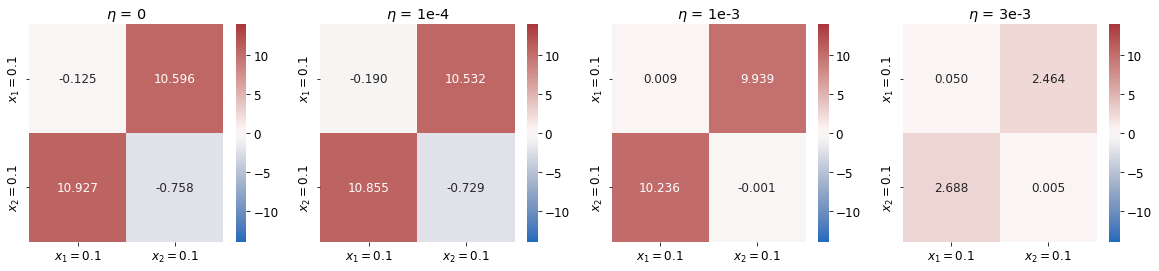

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", family="Times New Roman", size=12)

eta = [0, "1e-4", "1e-3", "3e-3"]
plt.figure(figsize=(20, 4))
for i in range(1, 5):
    ax = plt.subplot(1,4,i)
    heatmap = sns.heatmap(times3(eval("eta_{}_R_state_1".format(i-1))), \
                          cmap="vlag", annot = eval("eta_{}_R_state_1".format(i-1)), \
                          fmt=".3f", cbar=True, vmax=14, vmin=-14, \
                          xticklabels = ['$x_1=0.1$','$x_2=0.1$'], yticklabels = ['$x_1=0.1$','$x_2=0.1$'])
    plt.title("$\eta$ = " + str(eta[i-1]))

plt.savefig("state_20", dpi=500, bbox_inches='tight')
plt.show()

# $\gamma_{state} = 10$

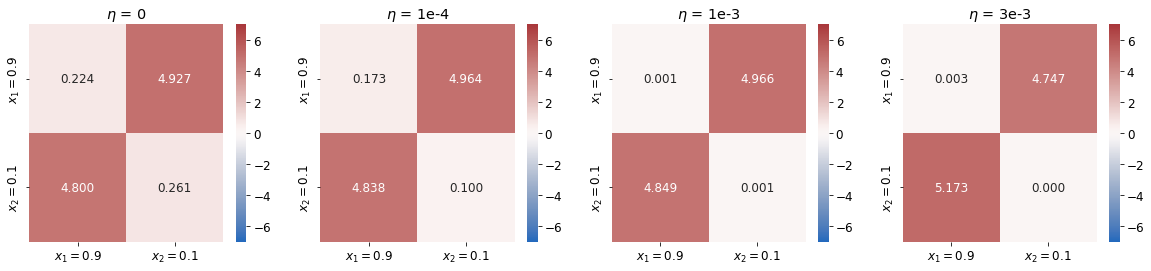

In [36]:
plt.rc("font", family="Times New Roman", size=12)
plt.figure(figsize=(20, 4))
for i in range(1, 5):
    ax = plt.subplot(1,4,i)
    heatmap = sns.heatmap(times3(eval("eta_{}_R_state_3".format(i-1))), \
                          cmap="vlag", annot = eval("eta_{}_R_state_3".format(i-1)), \
                          fmt=".3f", cbar=True, vmax=7, vmin=-7, \
                          xticklabels = ['$x_1=0.9$','$x_2=0.1$'], yticklabels = ['$x_1=0.9$','$x_2=0.1$'])
    plt.title("$\eta$ = " + str(eta[i-1]))

plt.savefig("state_10", dpi=500, bbox_inches='tight')
plt.show()

# $\gamma_{state} = -10$

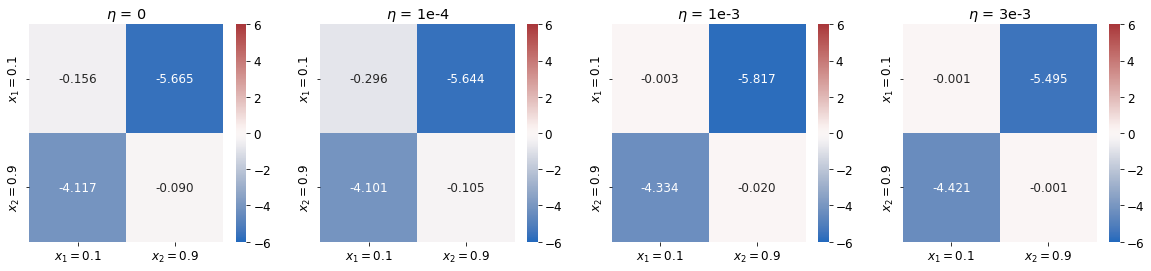

In [37]:
plt.rc("font", family="Times New Roman", size=12)

plt.figure(figsize=(20, 4))
for i in range(1, 5):
    ax = plt.subplot(1,4,i)
    heatmap = sns.heatmap(times3(eval("eta_{}_R_state_2".format(i-1))), \
                          cmap="vlag", annot = eval("eta_{}_R_state_2".format(i-1)), \
                          fmt=".3f", cbar=True, vmax=6, vmin=-6, \
                          xticklabels = ['$x_1=0.1$','$x_2=0.9$'], yticklabels = ['$x_1=0.1$','$x_2=0.9$'])
    plt.title("$\eta$ = " + str(eta[i-1]))

plt.savefig("state_-10", dpi=500, bbox_inches='tight')
plt.show()

# $\gamma_{state} = -5$

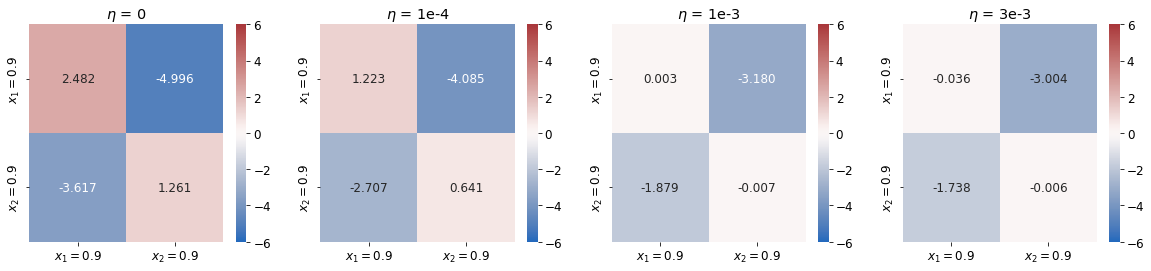

In [38]:
plt.rc("font", family="Times New Roman", size=12)
plt.figure(figsize=(20, 4))
for i in range(1, 5):
    ax = plt.subplot(1,4,i)
    heatmap = sns.heatmap((eval("eta_{}_R_state_4".format(i-1))), \
                          cmap="vlag", annot = eval("eta_{}_R_state_4".format(i-1)), \
                          fmt=".3f", cbar=True, vmax=6, vmin=-6, \
                          xticklabels = ['$x_1=0.9$','$x_2=0.9$'], yticklabels = ['$x_1=0.9$','$x_2=0.9$'])
    plt.title("$\eta$ = " + str(eta[i-1]))

plt.savefig("state_-5", dpi=500, bbox_inches='tight')
plt.show()

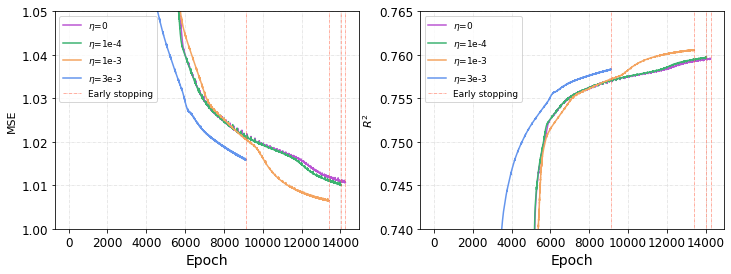

In [41]:
plt.rc("font", family="Times New Roman", size=12)
plt.figure(figsize=(12, 4))

# MSE
ax1 = plt.subplot(1,2,1)
plt.plot(range(len(eta_0_loss_list)), eta_0_loss_list, label = '$\eta$=0', color='mediumorchid')
plt.plot(np.array([len(eta_0_loss_list), len(eta_0_loss_list)]), np.array([1, 1.05]), ls = "-.", linewidth=0.5, color='tomato')
plt.plot(range(len(eta_1_loss_list)), eta_1_loss_list, label = '$\eta$=1e-4', color='mediumseagreen')
plt.plot(np.array([len(eta_1_loss_list), len(eta_1_loss_list)]), np.array([1, 1.05]), ls = "-.", linewidth=0.5, color='tomato')
plt.plot(range(len(eta_2_loss_list)), eta_2_loss_list, label = '$\eta$=1e-3', color='sandybrown')
plt.plot(np.array([len(eta_2_loss_list), len(eta_2_loss_list)]), np.array([1, 1.05]), ls = "-.", linewidth=0.5, color='tomato')
plt.plot(range(len(eta_3_loss_list)), eta_3_loss_list, label = '$\eta$=3e-3', color='cornflowerblue')
plt.plot(np.array([len(eta_3_loss_list), len(eta_3_loss_list)]), np.array([1, 1.05]), ls = "-.", linewidth=0.5, color='tomato', label="Early stopping")
plt.legend(loc='upper left',prop = {'size':9})
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("MSE", fontsize=11)
plt.ylim(1, 1.05)
plt.grid(ls="dashdot", linewidth=0.5, color='lightgray', zorder=0)

# R_2
ax2 = plt.subplot(1,2,2)
plt.ylim(0.74, 0.765)
plt.plot(range(len(eta_0_loss_list)), eta_0_R2_list, label = '$\eta$=0', color='mediumorchid')
plt.plot(np.array([len(eta_0_loss_list), len(eta_0_loss_list)]), np.array([0.7, 0.8]), ls = "-.", linewidth=0.5, color='tomato')
plt.plot(range(len(eta_1_loss_list)), eta_1_R2_list, label = '$\eta$=1e-4', color='mediumseagreen')
plt.plot(np.array([len(eta_1_loss_list), len(eta_1_loss_list)]), np.array([0.7, 0.8]), ls = "-.", linewidth=0.5, color='tomato')
plt.plot(range(len(eta_2_loss_list)), eta_2_R2_list, label = '$\eta$=1e-3', color='sandybrown')
plt.plot(np.array([len(eta_2_loss_list), len(eta_2_loss_list)]), np.array([0.7, 0.8]), ls = "-.", linewidth=0.5, color='tomato')
plt.plot(range(len(eta_3_loss_list)), eta_3_R2_list, label = '$\eta$=3e-3', color='cornflowerblue')
plt.plot(np.array([len(eta_3_loss_list), len(eta_3_loss_list)]), np.array([0.7, 0.8]), ls = "-.", linewidth=0.5, color='tomato', label="Early stopping")
plt.grid(ls="dashdot", linewidth=0.5, color='lightgray', zorder=0)
plt.ylabel("$R^2$", fontsize=11)
plt.legend(loc='upper left',prop = {'size':9})
plt.xlabel("Epoch", fontsize=14)
plt.savefig("loss", dpi=500, bbox_inches='tight')
plt.show()

In [32]:
# The coefficient of x_1x_2 are obtained by summing the secondary diagonal of R
def get_c(array):
    return array[0][1] + array[1][0]

In [33]:
result = []
for i in np.arange(0.9, -0.1, -0.1):
    for j in np.arange(0, 1, 0.1):
        R = model(torch.tensor([[i, j]],dtype=torch.float32))[1][0].detach().numpy()
        result.append(get_c(R))

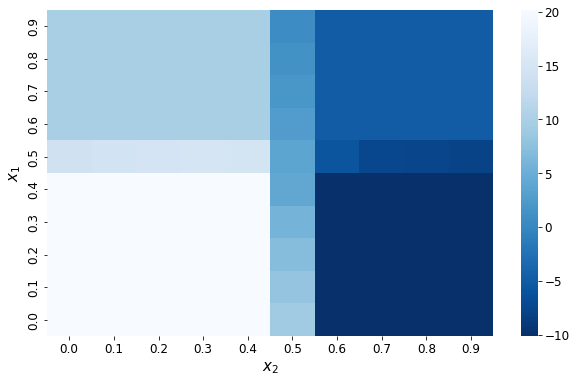

In [42]:
plt.rc('font', family = 'Times New Roman', size = '12')
plt.figure(figsize=(10, 6))
h = sns.heatmap(np.array(result).reshape(10,10), cmap="Blues_r",xticklabels = np.arange(0,10,1) / 10, yticklabels = np.arange(9,-1,-1) / 10, cbar=True)

plt.xlabel("$x_2$", size=15)
plt.ylabel("$x_1$", size=15)
plt.savefig('TENSOR_1', dpi=500, bbox_inches='tight')
plt.show()